In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('./data/protein_data.csv')
from sklearn.model_selection import train_test_split

# df_sampled, _ = train_test_split(
#     data,
#     stratify=data['classification'],
#     # train_size=10_000,
#     train_size=20_000,
#     random_state=42
# )
df_sampled = data
df_sampled.head()

,sequence,classification
0,AQLVDSMPSASTGSVVVTDDLNYWGGRRIKSKDGATTEPVFEPATG...,OXIDOREDUCTASE
1,MGAFLDKPKMEKHNAQGQGNGLRYGLSSMQGWRVEMEDAHTAVIGL...,HYDROLASE
2,STAGKVIKCKAAVLWEEKKPFSIEEVEVAPPKAHEVRIKMVATGIC...,OXIDOREDUCTASE
3,KETAAAKFERQHMDSSTSAASSSNYCNQMMKSRNLTKDRCKPVNTF...,HYDROLASE
4,IVGGYTCQENSVPYQVSLNSGYHFCGGSLINDQWVVSAAHCYKSRI...,HYDROLASE


In [3]:
len(df_sampled)

33864

In [4]:
df_sampled['classification'].value_counts()

classification
OXIDOREDUCTASE    8466
HYDROLASE         8466
TRANSFERASE       8466
IMMUNE SYSTEM     8466
Name: count, dtype: int64

In [5]:
X = df_sampled['sequence']
y = df_sampled['classification']

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
class_names = le.classes_
n_classes = len(class_names)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [6]:
avg_char_len = X_train.str.len().mean()
print(f"Average character length: {avg_char_len:.2f}")

Average character length: 289.01


In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)

def preprocess_sequence(sequence):
    return ' '.join(list(sequence.strip()))

def tokenize_sequences(sequences, max_length=250):
    sequences = [preprocess_sequence(seq) for seq in sequences]
    return tokenizer(
        sequences,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader

class ProteinDataset(Dataset):
    def __init__(self, sequences, labels, max_length=250):
        self.labels = labels
        tokenized = tokenize_sequences(sequences, max_length=max_length)
        self.input_ids = tokenized["input_ids"]
        self.attention_mask = tokenized["attention_mask"]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = ProteinDataset(X_train.tolist(), y_train.tolist())
val_dataset = ProteinDataset(X_val.tolist(), y_val.tolist())
test_dataset = ProteinDataset(X_test.tolist(), y_test.tolist())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [9]:
import torch.nn as nn
from transformers import BertModel

class ProteinClassifier(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.bert = BertModel.from_pretrained("Rostlab/prot_bert")
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_labels)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        return self.classifier(x)


In [10]:
import torch
import numpy as np

class EarlyStopping:
    def __init__(self, patience=3, delta=0, path="checkpoint.pt", verbose=False):
        """
        Args:
            patience (int): How many epochs to wait after last improvement.
            delta (float): Minimum change in monitored metric to qualify as improvement.
            path (str): File path to save the best model.
            verbose (bool): Print messages when improvement happens.
        """
        self.patience = patience
        self.delta = delta
        self.path = path
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decreases."""
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} → {val_loss:.6f}). Saving model...")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [11]:
import time
from sklearn.metrics import accuracy_score
from torch.optim import AdamW
from torch.amp import autocast, GradScaler
from transformers import get_linear_schedule_with_warmup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ProteinClassifier(num_labels=n_classes).to(device)

# Freeze all first
for name, param in model.bert.named_parameters():
    param.requires_grad = False

# Unfreeze last 12 layers only (18–29)
for name, param in model.bert.named_parameters():
    if any(f"encoder.layer.{i}" in name for i in range(18, 30)):
        param.requires_grad = True

# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
optimizer = AdamW([
    {"params": model.bert.parameters(), "lr": 2e-5},        # pretrained encoder (small LR)
    {"params": model.classifier.parameters(), "lr": 1e-4},  # classifier head (larger LR)
], weight_decay=0.01)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

EPOCHS = 40

# History dictionary
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epoch_time': []
}

scaler = GradScaler("cuda")

early_stopping = EarlyStopping(patience=5, verbose=True, path="./models/protbert_v4.pt")

total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

for epoch in range(EPOCHS):
    start_time = time.time()
    model.train()
    total_loss = 0
    all_train_preds = []
    all_train_labels = []

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        
        with autocast(device_type="cuda", dtype=torch.float16):
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        
        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

    avg_train_loss = total_loss / len(train_loader)
    train_acc = accuracy_score(all_train_labels, all_train_preds)

    model.eval()
    val_loss = 0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            with autocast(device_type="cuda", dtype=torch.float16):
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)
            
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = accuracy_score(all_val_labels, all_val_preds)
    
    elapsed = time.time() - start_time

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f} | "
          f"Time: {elapsed:.2f}s")

    # Save to history
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_acc)
    history['epoch_time'].append(elapsed)

    early_stopping(avg_val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break


Epoch 1/40 | Train Loss: 1.1617 | Train Acc: 0.4352 | Val Loss: 1.0082 | Val Acc: 0.4948 | Time: 243.52s
Validation loss decreased (inf → 1.008239). Saving model...
Epoch 2/40 | Train Loss: 0.8681 | Train Acc: 0.7306 | Val Loss: 0.6800 | Val Acc: 0.8948 | Time: 243.52s
Validation loss decreased (1.008239 → 0.680019). Saving model...
Epoch 3/40 | Train Loss: 0.6007 | Train Acc: 0.9098 | Val Loss: 0.6286 | Val Acc: 0.8653 | Time: 243.28s
Validation loss decreased (0.680019 → 0.628582). Saving model...
Epoch 4/40 | Train Loss: 0.5286 | Train Acc: 0.9253 | Val Loss: 0.6702 | Val Acc: 0.8642 | Time: 243.31s
EarlyStopping counter: 1 out of 5
Epoch 5/40 | Train Loss: 0.5457 | Train Acc: 0.9142 | Val Loss: 0.5609 | Val Acc: 0.8967 | Time: 244.08s
Validation loss decreased (0.628582 → 0.560886). Saving model...
Epoch 6/40 | Train Loss: 0.7684 | Train Acc: 0.8326 | Val Loss: 0.5932 | Val Acc: 0.9221 | Time: 243.25s
EarlyStopping counter: 1 out of 5
Epoch 7/40 | Train Loss: 0.6255 | Train Acc: 0.

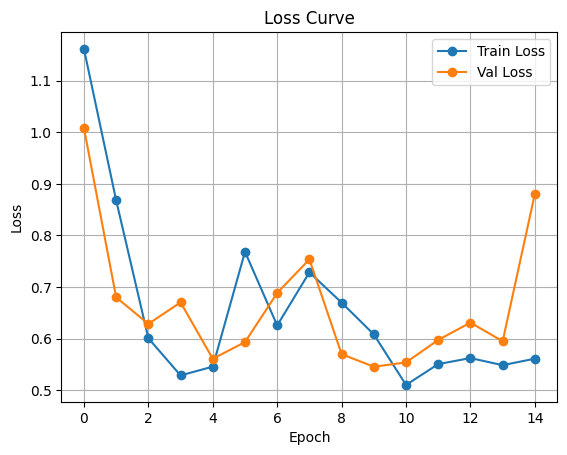

In [12]:
import matplotlib.pyplot as plt

plt.plot(history['train_loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Val Loss', marker='o')
plt.legend()
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

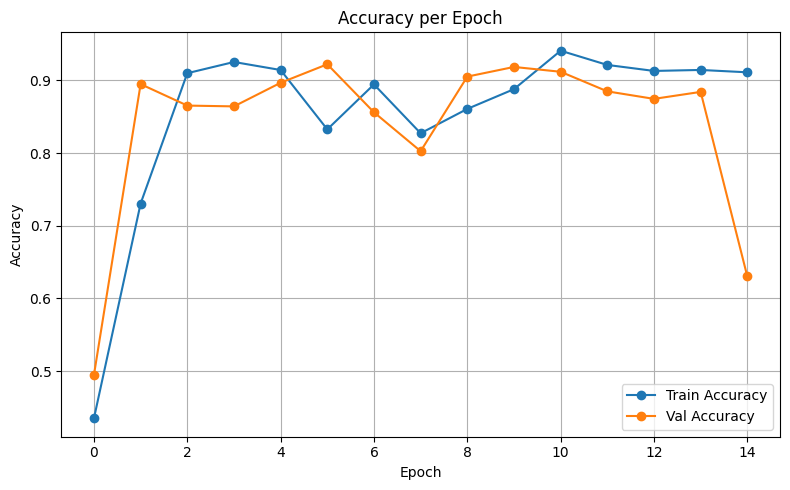

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(history['train_acc'], label='Train Accuracy', marker='o')
plt.plot(history['val_acc'], label='Val Accuracy', marker='o')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
test_loader = DataLoader(test_dataset, batch_size=16)

model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_acc = accuracy_score(test_labels, test_preds)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.6192


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds, average="weighted")
recall = recall_score(test_labels, test_preds, average="weighted")
f1 = f1_score(test_labels, test_preds, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.6192
Precision: 0.6513
Recall: 0.6192
F1 Score: 0.6155


In [16]:
from sklearn.metrics import classification_report, confusion_matrix

In [17]:
print(classification_report(test_labels, test_preds))

              precision    recall  f1-score   support

           0       0.92      0.62      0.74      1728
           1       0.32      0.23      0.27      1674
           2       0.86      0.81      0.83      1737
           3       0.48      0.81      0.61      1634

    accuracy                           0.62      6773
   macro avg       0.65      0.62      0.61      6773
weighted avg       0.65      0.62      0.62      6773



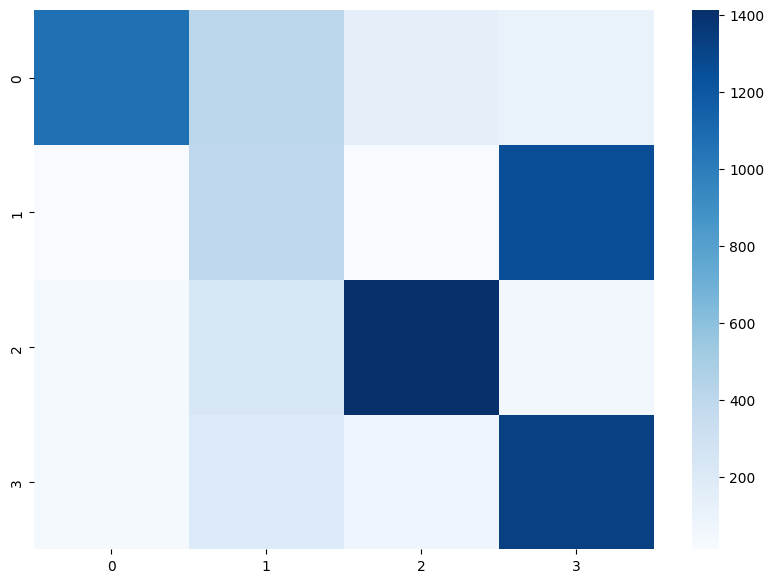

In [18]:
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10,7))
sns.heatmap(cm, cmap='Blues');